# Frequency and the fast Fourier transform

> If you want to find the secrets of the universe, think in terms of energy,
> frequency and vibration.
>
> — Nikola Tesla

*This chapter was written in collaboration with SW's father, PW van der Walt.*

This chapter will depart slightly from the format of the rest of the
book.  In particular, you may find the *code* in the chapter quite
modest.  Instead, we want to illustrate an elegant *algorithm*, the
Fast Fourier Transform (FFT), that is endlessly useful, implemented in
SciPy, and works, of course, on NumPy arrays.

## Introducing frequency

We'll start by setting up some plotting styles and importing the usual
suspects:

In [2]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('style/elegant.mplstyle')

In [3]:
import numpy as np

The discrete[^discrete] Fourier transform (DFT) is a mathematical technique
to convert temporal or spatial data into *frequency domain* data.
*Frequency* is a familiar concept, due to its colloquial occurrence in
the English language: the lowest notes your headphones can rumble out
are around 20 Hertz, whereas middle C on a piano lies around 261.6
Hertz.  Hertz (Hz), or oscillations per second, in this case literally
refers to the number of times per second at which the membrane inside
the headphone moves to-and-fro.  That, in turn, creates compressed
pulses of air which, upon arrival at your eardrum, induces a vibration
at the same frequency.  So, if you take a simple periodic function, $\sin(10 \times 2 \pi t)$, you can view it as a wave:

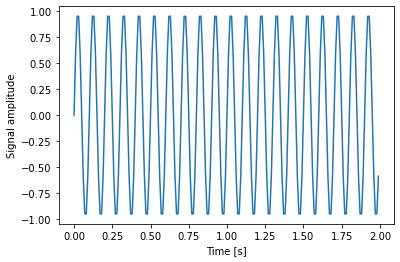

In [4]:
f = 10  # Frequency, in cycles per second, or Hertz
f_s = 100  # Sampling rate, or number of measurements per second

t = np.linspace(0, 2, 2 * f_s, endpoint=False)
x = np.sin(f * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

<!-- caption text="A simple periodic function in time" -->

[^discrete]: The discrete Fourier transform operates on sampled data,
             in contrast to the standard Fourier transform which is
             defined for continuous functions.

Or you can equivalently think of it as a repeating signal of
*frequency* 10 Hertz (it repeats once every $1/10$ seconds—a length of
time we call its *period*).  Although we naturally associate frequency
with time, it can equally well be applied to space.  E.g., a
photo of a textile patterns exhibits high *spatial frequency*, whereas
the sky or other smooth objects have low spatial frequency.

Let us now examine our sinusoid through application of the discrete Fourier
transform:

(-5.0, 110.0)

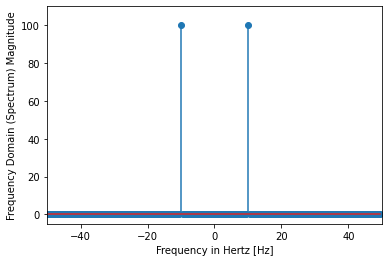

In [5]:
from scipy import fftpack

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

<!-- caption text="Frequencies that make up our periodic signal above" -->

We see that the output of the FFT is a one-dimensional array of the
same shape as the input, containing complex values.  All values are
zero, except for two entries.  Traditionally, we visualize the
magnitude of the result as a *stem plot*, in which the height of each
stem corresponds to the underlying value.

(We explain why you see positive and negative frequencies later on
in the sidebox titled "Discrete Fourier transforms".  You may also
refer to that section for a more in-depth overview of the underlying
mathematics.)

The Fourier transform takes us from the *time* to the *frequency*
domain, and this turns out to have a massive number of applications.
The *fast Fourier transform* is an algorithm for computing the
discrete Fourier transform; it achieves its high speed by storing and
re-using results of computations as it progresses.

In this chapter, we examine a few applications of the discrete Fourier
transform to demonstrate that the FFT can be applied to
multidimensional data (not just 1D measurements) to achieve a variety
of goals.

## Illustration: a birdsong spectrogram

Let's start with one of the most common applications, converting a sound signal (consisting of variations of air pressure over time) to a *spectrogram*.
You might have seen spectrograms on your music player's equalizer view, or even on an old-school stereo.

![The Numark EQ2600 Stereo Equalizer; image used with permission from the author, Sergey Gerasimuk. Source: http://sgerasimuk.blogspot.com/2014/06/numark-eq-2600-10-band-stereo-graphic.html](../images/sergey_gerasimuk_numark-eq-2600-IMG_0236.JPG)

Listen to the following snippet of nightingale birdsong (released under CC BY 4.0 at
http://www.orangefreesounds.com/nightingale-sound/):

In [6]:
from IPython.display import Audio
Audio('data/nightingale.wav')

ValueError: rate must be specified when data is a numpy array or list of audio samples.

If you are reading the paper version of this book, you'll have to use
your imagination!  It goes something like this:
chee-chee-woorrrr-hee-hee cheet-wheet-hoorrr-chi
rrr-whi-wheo-wheo-wheo-wheo-wheo-wheo.

Since we realise that not everyone is fluent in bird-speak, perhaps
it's best if we visualize the measurements—better known as "the
signal"—instead.

We load the audio file, which gives us
the sampling rate (number of measurements per second) as well as audio
data as an `(N, 2)` array—two columns because this is a stereo
recording.

In [ ]:
from scipy.io import wavfile

rate, audio = wavfile.read('data/nightingale.wav')

We convert to mono by averaging the left and right channels.

In [ ]:
audio = np.mean(audio, axis=1)

Then, calculate the length of the snippet and plot the audio.

In [ ]:
N = audio.shape[0]
L = N / rate

print(f'Audio length: {L:.2f} seconds')

f, ax = plt.subplots()
ax.plot(np.arange(N) / rate, audio)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

<!-- caption text="Audio waveform plot of birdsong" -->

Well, that's not very satisfying, is it?  If I sent this voltage to a
speaker, I might hear a bird chirping, but I can't very well imagine
how it would sound like in my head.  Is there a better way of *seeing*
what is going on?

There is, and it is called the discrete Fourier transform, where
discrete refers to the recording consisting of time-spaced sound
measurements, in contrast to a continual recording as, e.g., on
magnetic tape (remember casettes?).  The discrete Fourier
transform is often computed using the *fast Fourier transform* (FFT)
algorithm, a name informally used to refer to the DFT itself. The
DFT tells us which frequencies or "notes" to expect in our signal.

Of course, a bird sings many notes throughout the song, so we'd also
like to know *when* each note occurs.  The Fourier transform takes a
signal in the time domain (i.e., a set of measurements over time) and
turns it into a spectrum—a set of frequencies with corresponding
(complex[^complex]) values.  The spectrum does not contain any information about
time! [^time]

[^complex]: The Fourier transform essentially tells us how to combine
            a set of sinusoids of varying frequency to form the input
            signal.  The spectrum consists of complex numbers—one for
            each sinusoid.  A complex number encodes two things: a
            magnitude and an angle.  The magnitude is the strength of
            the sinusoid in the signal, and the angle how much it is
            shifted in time.  At this point, we only care about the
            magnitude, which we calculate using ``np.abs``.

[^time]: For more on techniques for calculating both (approximate) frequencies
         and time of occurrence, read up on wavelet analysis.

So, to find both the frequencies and the time at which they were sung,
we'll need to be somewhat clever.  Our strategy is as follows:
take the audio signal, split it into small, overlapping slices, and
apply the Fourier transform to each (a technique known as the Short
Time Fourier Transform).

We'll split the signal into slices of 1024 samples—that's about 0.02
seconds of audio.  Why we choose 1024 and not 1000 we'll explain in a
second when we examine performance.  The slices will overlap by 100
samples as shown here:

![A sliding window operation](../figures/generated/sliding_window.png)

Start by chopping up the signal into slices of 1024 samples, each
slice overlapping the previous by 100 samples.  The resulting `slices`
object contains one slice per row.

In [ ]:
from skimage import util

M = 1024

slices = util.view_as_windows(audio, window_shape=(M,), step=100)
print(f'Audio shape: {audio.shape}, Sliced audio shape: {slices.shape}')

Generate a windowing function (see the section on windowing for a
discussion of the underlying assumptions and interpretations of each)
and multiply it with the signal:

In [ ]:
win = np.hanning(M + 1)[:-1]
slices = slices * win

It's more convenient to have one slice per column, so we take the transpose:

In [ ]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

For each slice, calculate the discrete Fourier transform.  The DFT
returns both positive and negative frequencies (more on that in
"Frequencies and their ordering"), so we slice out the positive M / 2
frequencies for now.

In [ ]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

(As a quick aside, you'll note that we use `scipy.fftpack.fft` and
`np.fft` interchangeably.  NumPy provides basic FFT functionality,
which SciPy extends further, but both include an `fft` function, based
on the Fortran FFTPACK.)

The spectrum can contain both very large and very small values.
Taking the log compresses the range significantly.

Here we do a log plot of the ratio of the signal divided by the maximum signal.
The specific unit used for the ratio is the decibel, $20
log_{10}\left(\mathrm{amplitude ratio}\right)$.

In [ ]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

<!-- caption text="Birdsong spectrogram" -->

Much better!  We can now see the frequencies vary over time, and it
corresponds to the way the audio sounds.  See if you can match my
earlier description: chee-chee-woorrrr-hee-hee cheet-wheet-hoorrr-chi
rrr-whi-wheo-wheo-wheo-wheo-wheo-wheo (I didn't transcribe the section
from 3 to 5 seconds—that's another bird).

SciPy already includes an implementation of this
procedure as ``scipy.signal.spectrogram``, which can be invoked as
follows:

In [ ]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(audio, fs=rate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

<!-- caption text="SciPy built-in rendition of birdsong spectrogram" -->

The only differences are that SciPy returns the spectrum magnitude
squared (which turns measured voltage into measured energy), and
multiplies it by some normalization factors[^scaling].

[^scaling]: SciPy goes to some effort to preserve the energy in the
            spectrum.  Therefore, when taking only half the components
            (for N even), it multiplies the remaining components,
            apart from the first and last components, by two (those
            two components are "shared" by the two halves of the
            spectrum).  It also normalizes the window by dividing it
            by its sum.

## History

Tracing the exact origins of the Fourier transform is tricky.  Some
related procedures go as far back as Babylonian times, but it was the
hot topics of calculating asteroid orbits and solving the heat (flow)
equation that led to several breakthroughs in the early 1800s.  Whom
exactly among Clairaut, Lagrange, Euler, Gauss and D'Alembert we
should thank is not exactly clear, but Gauss was the first to describe
the fast Fourier transform (an algorithm for computing the discrete
Fourier transform, popularized by Cooley and Tukey in 1965).  Joseph
Fourier, after whom the transform is named, first claimed that
*arbitrary* periodic [^periodic] functions can be expressed as a sum of
trigonometric functions.

[^periodic]: The period can, in fact, also be infinite!  The general
             continuous Fourier transform provides for this
             possibility.  Discrete Fourier transforms are generally
             defined over a finite interval, and this is implicitly
             the period of the time domain function that is
             transformed.  In other words, if you do the inverse
             discrete Fourier transform, you *always* get a periodic
             signal out.

## Implementation

The discrete Fourier transform functionality in SciPy lives in the
`scipy.fftpack`` module.  Among other things, it provides the
following DFT-related functionality:

 - ``fft``, ``fft2``, ``fftn``: Compute the discrete Fourier transform using
   the Fast Fourier Transform algorithm in 1, 2, or `n` dimensions.
 - ``ifft``, ``ifft2``, ``ifftn``: Compute the inverse of the DFT
 - ``dct``, ``idct``, ``dst``, ``idst``: Compute the cosine and sine transforms, and their inverses.
 - ``fftshift``, ``ifftshift``: Shift the zero-frequency component to the center of the spectrum and back, respectively (more about that soon).
 - ``fftfreq``: Return the discrete Fourier transform sample frequencies.
 - ``rfft``: Compute the DFT of a real sequence, exploiting the symmetry of the resulting spectrum for increased performance.  Also used by ``fft`` internally when applicable.

This is complemented by the following functions in NumPy:

 - ``np.hanning``, ``np.hamming``, ``np.bartlett``, ``np.blackman``,
   ``np.kaiser``: Tapered windowing functions.

It is also used to perform fast convolutions of large inputs by
`scipy.signal.fftconvolve`.

SciPy wraps the Fortran FFTPACK library—it is not the fastest out
there, but unlike packages such as FFTW, it has a permissive free
software license.

## Choosing the length of the discrete Fourier transform (DFT)

A naive calculation of the DFT takes $\mathcal{O}\left(N^2\right)$ operations [^big_O].
How come?  Well, you have $N$
(complex) sinusoids of different frequencies ($2 \pi f \times 0, 2 \pi f \times
1, 2 \pi f \times 3, ..., 2 \pi f \times (N - 1)$), and you want to see how
strongly your signal corresponds to each.  Starting with the first,
you take the dot product with the signal (which, in itself, entails $N$
multiplication operations).  Repeating this operation $N$ times, once
for each sinusoid, then gives $N^2$ operations.

[^big_O]: In computer science, the computational cost of an algorithm
          is often expressed in "Big O" notation.  The notation gives
          us an indication of how an algorithm's execution time scales
          with an increasing number of elements.  If an algorithm is $\mathcal{O}(N)$,
          it means its execution time increases linearly with
          the number of input elements (for example, searching for a
          given value in an unsorted list is $\mathcal{O}\left(N\right)$).  Bubble sort is
          an example of an $O\left(N^2\right)$ algorithm; the exact number of
          operations performed may, hypothetically, be $N + \frac{1}{2} N^2$,
          meaning that the computational cost grows quadratically with
          the number of input elements.

Now, contrast that with the fast Fourier transform, which is $\mathcal{O}\left(N \log N\right)$ in
the ideal case due to the clever re-use of
calculations—a great improvement!  However, the classical Cooley-Tukey
algorithm implemented in FFTPACK (and used by SciPy) recursively breaks up the transform
into smaller (prime-sized) pieces and only shows this improvement for
"smooth" input lengths (an input length is considered smooth when its
largest prime factor is small).  For large prime-sized pieces, the
Bluestein or Rader algorithms can be used in conjunction with the
Cooley-Tukey algorithm, but this optimization is not implemented in
FFTPACK.[^fast]

Let us illustrate:

In [ ]:
import time

from scipy import fftpack
from sympy import factorint

K = 1000
lengths = range(250, 260)

# Calculate the smoothness for all input lengths
smoothness = [max(factorint(i).keys()) for i in lengths]


exec_times = []
for i in lengths:
    z = np.random.random(i)

    # For each input length i, execute the FFT K times
    # and store the execution time

    times = []
    for k in range(K):
        tic = time.monotonic()
        fftpack.fft(z)
        toc = time.monotonic()
        times.append(toc - tic)

    # For each input length, remember the *minimum* execution time
    exec_times.append(min(times))


f, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
ax0.stem(lengths, np.array(exec_times) * 10**6)
ax0.set_ylabel('Execution time (µs)')

ax1.stem(lengths, smoothness)
ax1.set_ylabel('Smoothness of input length\n(lower is better)')
ax1.set_xlabel('Length of input');

<!-- caption text="FFT execution time vs smoothness for different input lengths" -->

The intuition is that, for smooth input lengths, the FFT can be broken up
into many small pieces. After performing the FFT on the first piece,
those results can be reused in subsequent computations.  This explains
why we chose a length of 1024 for our audio slices earlier—it has a
smoothness of only 2, resulting in the optimal "radix-2 Cooley-Tukey"
algorithm, which computes the FFT using only $(N/2) \log_2 N = 5120$ complex
multiplications, instead of $N^2 = 1048576$.  Choosing $N = 2^m$
always ensures a maximally smooth $N$ (and, thus, the fastest FFT).

[^fast]: While ideally we don't want to reimplement existing
         algorithms, sometimes it becomes necessary in order to obtain
         the best execution speeds possible, and tools
         like [Cython](http://cython.org)—which compiles Python to
         C—and [Numba](http://numba.pydata.org)—which does
         just-in-time compilation of Python code—make life a lot
         easier (and faster!).  If you are able to use GPL-licenced
         software, you may consider
         using [PyFFTW](https://github.com/hgomersall/pyFFTW) for
         faster FFTs.

## More discrete Fourier transform concepts

Next, we present a couple of common concepts worth knowing before
operating heavy Fourier transform machinery, whereafter we tackle
another real-world problem: analyzing target detection in radar data.

### Frequencies and their ordering

For historical reasons, most implementations return an array where
frequencies vary from low-to-high-to-low (see the box "Discrete
Fourier transforms" for further explanation of frequencies).  E.g., when we do the real
Fourier transform of a signal of all ones, an input that has no
variation and therefore only has the slowest, constant Fourier
component (also known as the "DC" or Direct Current component—just
electronics jargon for "mean of the signal"), we see this DC component 
appearing as the first entry:

In [ ]:
from scipy import fftpack
N = 10

fftpack.fft(np.ones(N))  # The first component is np.mean(x) * N

When we try the FFT on a rapidly changing signal, we see a high
frequency component appear:

In [ ]:
z = np.ones(10)
z[::2] = -1

print(f'Applying FFT to {z}')
fftpack.fft(z)

Note that the FFT returns a complex spectrum which, in the case of
real inputs, is conjugate symmetrical (i.e., symmetric in the real
part, and anti-symmetric in the imaginary part):

In [ ]:
x = np.array([1, 5, 12, 7, 3, 0, 4, 3, 2, 8])
X = fftpack.fft(x)

with np.printoptions(precision=2):
    print("Real part:     ", X.real)
    print("Imaginary part:", X.imag)

(And, again, recall that the first component is ``np.mean(x) * N``.)

The `fftfreq` function tells us which frequencies we are looking at
specifically:

In [ ]:
fftpack.fftfreq(10)

The result tells us that our maximum component occured at a frequency
of 0.5 cycles per sample.  This agrees with the input, where a
minus-one-plus-one cycle repeated every second sample.

Sometimes, it is convenient to view the spectrum organized slightly
differently, from high-negative to low to-high-positive (for now, we
won't dive too deeply into the concept of negative frequency, other
than saying a real-world sine wave is produced by a combination of
positive and negative frequencies).  We re-shuffle the spectrum using
the `fftshift` function.

> **Discrete Fourier transforms {.callout}**
>
> The Discrete Fourier Transform (DFT) converts a sequence of $N$
> equally spaced real or complex samples $x_{0},x_{1},\ldots, x_{N-1}$ of
> a function $x(t)$ of time (or another variable, depending on the
> application) into a sequence of $N$ complex numbers $X_{k}$ by the
> summation
>
> $$X_{k}=\sum_{n=0}^{N-1}x_{n}e^{-j2\pi kn/N},\;k=0,1,\ldots,
> N-1.$$
>
> With the numbers $X_{k}$ known, the inverse DFT *exactly* recovers the
> sample values $x_{n}$ through the summation
>
> $$x_{n}=\frac{1}{N}\sum_{k=0}^{N-1}X_{k}e^{j2\pi kn/N}.$$
>
> Keeping in mind that $e^{j\theta}=\cos\theta+j\sin\theta,$ the last
> equation shows that the DFT has decomposed the sequence $x_{n}$ into a
> complex discrete Fourier series with coefficients $X_{k}$. Comparing
> the DFT with a continuous complex Fourier series
>
> $$x(t)=\sum_{n=-\infty}^{\infty}c_{n}e^{jn\omega_{0}t},$$
>
> the DFT is a *finite* series with $N$ terms defined at the equally
> spaced discrete instances of the *angle* $(\omega_{0}t_{n})=2\pi\frac{k}{N}$
> in the interval $[0,2\pi)$,
> i.e. *including* $0$  and *excluding* $2\pi$.
> This automatically normalizes the DFT so that time does
> not appear explicitly in the forward or inverse transform.
>
> If the original function $x(t)$ is limited in frequency to less than
> half of the sampling frequency (the so-called *Nyquist frequency*),
> interpolation between sample values produced by the inverse DFT will
> usually give a faithful reconstruction of $x(t)$. If $x(t)$ is *not*
> limited as such, the inverse DFT can, in general, not be used to
> reconstruct $x(t)$ by interpolation.  Note that this limit does not
> imply that there are *no* methods that can do such a
> reconstruction—see, e.g., compressed sensing, or finite rate of
> innovation sampling.
>
> The function $e^{j2\pi k/N}=\left(e^{j2\pi/N}\right)^{k}=w^{k}$ takes on
> discrete values between $0$ and $2\pi\frac{N-1}{N}$ on the unit circle in
> the complex plane. The function $e^{j2\pi kn/N}=w^{kn}$ encircles the
> origin $n\frac{N-1}{N}$ times, thus generating harmonics of the fundamental
> sinusoid for which $n=1$.
>
> The way in which we defined the DFT leads to a few subtleties
> when $n>\frac{N}{2}$, for even $N$ [^odd_N]. The function $e^{j2\pi kn/N}$ is plotted
> for increasing values of $k$ in the figure below,
> for the cases $n=1$ to $n=N-1$ for $N=16$. When $k$ increases from $k$
> to $k+1$, the angle increases by $\frac{2\pi n}{N}$. When $n=1$,
> the step is $\frac{2\pi}{N}$. When $n=N-1$, the angle
> increases by $2\pi\frac{N-1}{N}=2\pi-\frac{2\pi}{N}$. Since $2\pi$
> is precisely once around the circle, the step equates to $-\frac{2\pi}{N}$,
> i.e. in the direction of a negative
> frequency. The components up to $N/2$ represent *positive* frequency
> components, those above $N/2$ up to $N-1$ represent *negative*
> frequencies. The angle increment for the component $N/2$
> for $N$ even advances precisely halfway around the circle for
> each increment in $k$ and can therefore be interpreted as either a
> positive or a negative frequency. This component of the DFT represents
> the Nyquist Frequency, i.e. half of the sampling frequency, and is
> useful to orientate oneself when looking at DFT graphics.
>
> The FFT in turn is simply a special and highly efficient algorithm for
> calculating the DFT. Whereas a straightforward calculation of the DFT
> takes of the order of $N^{2}$ calculations to compute, the FFT
> algorithm requires of the order $N\log N$ calculations. The FFT was
> the key to the wide-spread use of the DFT in real-time applications
> and was included in a list of the top $10$ algorithms of the $20^{th}$
> century by the IEEE journal Computing in Science & Engineering in the
> year $2000$.
>
> ![Unit circle samples](../figures/unit_circle_samples.png)

[^odd_N]: We leave it as an exercise for the reader to picture the
          situation for $N$ odd.  In this chapter, all examples use
          even-order DFTs.

Let's examine the frequency components in a noisy image.  Note that,
while a static image has no time-varying component, its values do vary
across *space*.  The DFT applies equally to either case.

First, load and display the image:

In [ ]:
from skimage import io
image = io.imread('images/moonlanding.png')
M, N = image.shape

f, ax = plt.subplots(figsize=(4.8, 4.8))
ax.imshow(image)

print((M, N), image.dtype)

<!-- caption text="A noisy image of the moon landing" -->

Do not adjust your monitor!  The image you are seeing is real,
although clearly distorted by either the measurement or transmission
equipment.

To examine the spectrum of the image, we use `fftn` (instead of `fft`)
to compute the DFT, since it has more than one dimension.  The
two-dimensional FFT is equivalent to taking the 1-D FFT across rows
and then across columns (or vice versa).

In [ ]:
F = fftpack.fftn(image)

F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)


Again, we take the log of the spectrum to compress the range of
values, before displaying:

In [ ]:
f, ax = plt.subplots(figsize=(4.8, 4.8))

ax.imshow(np.log(1 + F_magnitude), cmap='viridis',
          extent=(-N // 2, N // 2, -M // 2, M // 2))
ax.set_title('Spectrum magnitude');

<!-- caption text="Spectrum of the noisy moon landing image (magnitude)" -->

Note the high values around the origin (middle) of the spectrum—these
coefficients describe the low frequencies or smooth parts of the
image; a vague canvas of the photo.  Higher frequency components,
spread throughout the spectrum, fill in the edges and detail.  Peaks
around higher frequencies correspond to the periodic noise.

From the photo, we can see that the noise (measurement artifacts) is
highly periodic, so we hope to remove it by zeroing out the
corresponding parts of the spectrum.

The image with those peaks suppressed indeed looks quite different!

In [ ]:
# Set block around center of spectrum to zero
K = 40
F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0

# Find all peaks higher than the 98th percentile
peaks = F_magnitude < np.percentile(F_magnitude, 98)

# Shift the peaks back to align with the original spectrum
peaks = fftpack.ifftshift(peaks)

# Make a copy of the original (complex) spectrum
F_dim = F.copy()

# Set those peak coefficients to zero
F_dim = F_dim * peaks.astype(int)

# Do the inverse Fourier transform to get back to an image
# Since we started with a real image, we only look at the real part of
# the output.
image_filtered = np.real(fftpack.ifft2(F_dim))

f, (ax0, ax1) = plt.subplots(2, 1, figsize=(4.8, 7))
ax0.imshow(fftpack.fftshift(np.log10(1 + np.abs(F_dim))), cmap='viridis')
ax0.set_title('Spectrum after suppression')

ax1.imshow(image_filtered)
ax1.set_title('Reconstructed image');

<!-- caption text="Filtered moon landing image and its spectrum" -->

### Windowing

If we examine the Fourier transform of a rectangular pulse, we see
significant sidelobes in the spectrum:

In [ ]:
x = np.zeros(500)
x[100:150] = 1

X = fftpack.fft(x)

f, (ax0, ax1) = plt.subplots(2, 1, sharex=True)

ax0.plot(x)
ax0.set_ylim(-0.1, 1.1)

ax1.plot(fftpack.fftshift(np.abs(X)))
ax1.set_ylim(-5, 55);

<!-- caption text="Spectrum of a rectangular pulse (magnitude)" -->

In theory, you would need a combination of infinitely many sinusoids
(frequencies) to represent any abrupt transition; the coefficients would
typically have the same sidelobe structure as seen here for the pulse.

Importantly, the discrete Fourier transform assumes that the input
signal is periodic.  If the signal is not, the assumption is simply
that, right at the end of the signal, it jumps back to its beginning
value.  Consider the function, $x(t)$, shown here:

<img src="../figures/periodic.png"/>
<!-- caption text="Eight samples have been taken of a given
 function with effective length $T_{eff}$.  With the discrete Fourier
 transform assuming periodicity, it creates a step discontinuity
 between the first and last samples." -->

We only measure the signal for a short time, labeled $T_{eff}$.  The
Fourier transform assumes that $x(8) = x(0)$, and that the signal is
continued as the dashed, rather than the solid line.  This introduces
a big jump at the edge, with the expected oscillation in the spectrum:

In [ ]:
t = np.linspace(0, 1, 500)
x = np.sin(49 * np.pi * t)

X = fftpack.fft(x)

f, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(x)
ax0.set_ylim(-1.1, 1.1)

ax1.plot(fftpack.fftfreq(len(t)), np.abs(X))
ax1.set_ylim(0, 190);

<!-- caption text="Spectrum oscillation due to signal edge discontinuity" -->

Instead of the expected two lines, the peaks are spread out in the
spectrum.

We can counter this effect by a process called *windowing*. The
original function is multiplied with a window function such as the
Kaiser window $K(N,\beta)$.  Here we visualize it for $\beta$ ranging
from 0 to 100:

In [ ]:
f, ax = plt.subplots()

N = 10
beta_max = 5
colormap = plt.cm.plasma

norm = plt.Normalize(vmin=0, vmax=beta_max)

lines = [
    ax.plot(np.kaiser(100, beta), color=colormap(norm(beta)))
    for beta in np.linspace(0, beta_max, N)
    ]

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

sm._A = []

plt.colorbar(sm).set_label(r'Kaiser $\beta$');

<!-- caption text="The Kaiser window for various values of $\beta$" -->

By changing the parameter $\beta$, the shape of the window can be
changed from rectangular ($\beta=0$, no windowing) to a window that
produces signals that smoothly increase from zero and decrease to zero
at the endpoints of the sampled interval, producing very low side
lobes ($\beta$ typically between 5 and 10) [^choosing_a_window].

[^choosing_a_window]: The classical windowing functions include Hann,
                      Hamming, and Blackman.  They differ in their
                      sidelobe levels and in the broadening of the
                      main lobe (in the Fourier domain).  A modern and
                      flexible window function that is close to
                      optimal for most applications is the Kaiser
                      window—a good approximation to the optimal
                      prolate spheroid window, which concentrates the
                      most energy into the main lobe.  The Kaiser
                      window can be tuned to suit the particular
                      application, as illustrated in the main text, by
                      adjusting the parameter $\beta$.

<!--
*For online notebook, use something like:*

#```
# @interact(beta=(0, 20.))
# def window(beta):
#    x = np.kaiser(1000, beta)
#    f, axes = plt.subplots(1, 2, figsize=(4.8, 2.4))
#    axes[0].plot(x)
#    axes[1].plot(fftpack.fftshift(np.abs(np.fft.fft(x, 10000))))
#    axes[1].set_xlim(2*2480, 2*2520)
#    plt.show()
#```
-->

The effect of windowing our previous example is noticeable:

In [ ]:
win = np.kaiser(len(t), 5)
x_win = x * win

X_win = fftpack.fft(x_win)

f, (ax0, ax1) = plt.subplots(2, 1)

ax0.plot(x_win)
ax0.set_ylim(-1.1, 1.1)

ax1.plot(fftpack.fftfreq(len(t)), np.abs(X_win))
ax1.set_ylim(0, 190);

<!-- caption text="Spectrum of a windowed signal (magnitude)" -->

## Real-world Application: Analyzing Radar Data

Linearly modulated FMCW (Frequency-Modulated Continuous-Wave) radars
make extensive use of the FFT algorithm for signal processing and
provide examples of various applications of the FFT. We will use actual
data from an FMCW radar to demonstrate one such an application: target
detection.

Roughly, an FMCW radar works like this (see box "A
simple FMCW radar system" for more detail):

A signal with changing frequency is generated.  This signal is
transmitted by an antenna, after which it travels outwards, away from the
radar.  When it hits an object, part of the signal is reflected back
to the radar, where it is received, multiplied by a copy of the
transmitted signal, and sampled, turning it into
numbers that are packed into an array.  Our challenge is to interpret
those numbers to form meaningful results.

The multiplication step above is important.  From school, recall the
trigonometric identity:

$
\sin(xt) \sin(yt) = \frac{1}{2}
\left[ \sin \left( (x - y)t + \frac{\pi}{2} \right) - \sin \left( (x + y)t + \frac{\pi}{2} \right) \right]
$

Thus, if we multiply the received signal by the transmitted signal, we
expect two frequency components to appear in the spectrum: one that is
the difference in frequencies between the received and transmitted
signal, and one that is the sum of their frequencies.

We are particularly interested in the first, since that gives us some
indication of how long it took the signal to reflect back to the radar
(in other words, how far away the object is from us!).  We discard the
other by applying a low-pass filter to the signal (i.e., a filter that
discards any high frequencies).

> **A simple FMCW radar system** {.callout}
>
> ![The block diagram of a simple FMCW radar system](../figures/FMCW_Block.png)
>
> A block diagram of a simple FMCW radar that uses separate
> transmit and receive antennas is shown above. The radar consists of a waveform generator
> that generates a sinusoidal signal of which the frequency varies
> linearly around the required transmit frequency. The generated signal
> is amplified to the required power level by the transmit amplifier
> and routed to the transmit antenna via a coupler circuit where a copy
> of the transmit signal is tapped off. The transmit antenna radiates
> the transmit signal as an electromagnetic wave in a narrow beam
> towards the target to be detected. When the wave encounters an object
> that reflects electromagnetic waves, a fraction of of the energy
> irradiating the target is reflected back to the receiver as a second
> electromagnetic wave that propagates in the direction of the radar
> system. When this wave encounters the receive antenna, the antenna
> collects the energy in the wave energy impinging on it and converts
> it to a fluctuating voltage that is fed to the mixer. The mixer
> multiplies the received signal with a replica of the transmit signal
> and produces a sinusoidal signal with a frequency equal to the
> difference in frequency between the transmitted and received
> signals. The low-pass filter ensures that the received signal is band
> limited (i.e., does not contain frequencies that we don't care about)
> and the receive amplifier strengthens the signal to a suitable
> amplitude for the analog to digital converter (ADC) that feeds data
> to the computer.

To summarize, we should note that:

 - The data that reaches the computer consists of $N$ samples sampled
   (from the multiplied, filtered signal) at a sample frequency of
   $f_{s}$.
 - The **amplitude** of the returned signal varies depending on the
   **strength of the reflection** (i.e., is a property of the target
   object and the distance between the target and the radar).
 - The **frequency measured** is an indication of the **distance** of the
   target object from the radar.

<!--

### Signal properties in the time domain

The transmit signal is a sinusoidal signal with an instantaneous
frequency that increases linearly with time, as shown in
Fig. [fig:FMCW waveform](a).

Starting at $f_{min}$, the frequency increases at a rate $S$ Hz/s to $f_{max}.$
The frequency is then decreased rapidly back to $f_{min}$
after which a next frequency sweep occurs.

This signal is radiated by a directional transmit antenna. When the
wave with propagation velocity $v\approx300\times10^{6}$ m/s (the
propagation speed of electromagnetic waves in air is ever-so-slightly
slower than the speed of light in a vacuum) hits a target at a range $R$,
the echo will reach the radar after a time

$$t_{d}=\frac{2R}{v}.$$

Here it is collected by the receive antenna and converted to a
sinusoidally fluctuating voltage. The received signal is a replica of
the transmitted signal, delayed by the transit time $t_{d}$ and is
shown dashed in Fig. [fig:FMCW waveform](b).

A radar is designed to detect targets up to a maximum range $R_{max}$.
Echoes from maximum range reach the radar after a transit
time $t_{dm}$ as shown in Fig. [fig:FMCW waveform](c).

We note that there is a constant difference in frequency between the
transmitted and received signals and this will be true for all targets
after time $t_{s}$ until $t_{e}$. We conclude from
Fig. [fig:FMCW waveform] that the frequency difference is given by

$$f_{d}=S\times t_{d}=\frac{2SR}{v},$$

where $T_{eff}=t_{e}-t_{s}=\frac{N}{f_{s}}$ is the effective sweep duration
of the radar. The frequency excursion of the sweep during $T_{eff}$ is
the effective bandwidth of the radar, given by

$$B_{eff}=f_{max}-f_{1}=ST_{eff}.$$

We will see that the range resolution of the radar is determined by
the effective bandwidth.


Returning to Fig. [fig: block-diagram], the signal produced by the
receiver at the input to the Analog to Digital Converter (ADC) when
there is a single target is a sinusoid with constant amplitude,
proportional to the amplitude of the echo, and constant frequency,
proportional to the range to the target.

-->

![The frequency relationships in an FMCW radar with
 linear frequency modulation](../figures/FMCW_waveform.png)

To start off, we'll generate some synthetic signals, after which we'll
turn our focus to the output of an actual radar.

Recall that the radar is increasing its frequency as it transmits at a
rate of $S$ Hz/s.  After a certain amount of time, $t$, has passed,
the frequency will now be $t S$ higher.  In that same time span, the
radar signal has traveled $d = t / v$ meters, where $v$ is the speed of
the transmitted wave through air (roughly the same as the speed of
light, $3 \times 10^8$ m/s).

Combining the above observations, we can calculate the amount of time
it would take the signal to travel to, bounce off, and return from a
target that is distance $R$ away:

$$ t_R = 2R / v $$

Therefore, the change in frequency for a target at range $R$ will be:

$$ f_{d}= t_R S = \frac{2RS}{v}$$

In [7]:
pi = np.pi

# Radar parameters
fs = 78125          # Sampling frequency in Hz, i.e. we sample 78125
                    # times per second

ts = 1 / fs         # Sampling time, i.e. one sample is taken each
                    # ts seconds

Teff = 2048.0 * ts  # Total sampling time for 2048 samples
                    # (AKA effective sweep duration) in seconds.

Beff = 100e6        # Range of transmit signal frequency during the time the
                    # radar samples, known as the "effective bandwidth"
                    # (given in Hz)

S = Beff / Teff     # Frequency sweep rate in Hz/s

# Specification of targets.  We made these targets up, imagining they
# are objects seen by the radar with the specified range and size

R = np.array([100, 137, 154, 159,  180])  # Ranges (in meter)
M = np.array([0.33, 0.2, 0.9, 0.02, 0.1])  # Target size
P = np.array([0, pi / 2, pi / 3, pi / 5, pi / 6])  # Randomly chosen phase offsets

t = np.arange(2048) * ts  # Sample times

fd = 2 * S * R / 3E8      # Frequency differences for these targets

# Generate five targets
signals = np.cos(2 * pi * fd * t[:, np.newaxis] + P)

# Save the signal associated with the first target as an example for
# later inspection
v_single = signals[:, 0]

# Weigh the signals, according to target size, and sum, to generate
# the combined signal seen by the radar
v_sim = np.sum(M * signals, axis=1)

## The above code is equivalent to:
#
# v0 = np.cos(2 * pi * fd[0] * t)
# v1 = np.cos(2 * pi * fd[1] * t + pi / 2)
# v2 = np.cos(2 * pi * fd[2] * t + pi / 3)
# v3 = np.cos(2 * pi * fd[3] * t + pi / 5)
# v4 = np.cos(2 * pi * fd[4] * t + pi / 6)
#
## Blend them together
# v_single = v0
# v_sim = (0.33 * v0) + (0.2 * v1) + (0.9 * v2) + (0.02 * v3) + (0.1 * v4)


Above, we generate a synthetic signal, $v_\mathrm{single}$, received when
looking at a single target (see figure below).  By counting the number
of cycles seen in a given time period, we can compute the frequency of
the signal and thus the distance to the target.

A real radar will rarely receive only a single echo, though. The
simulated signal $v_\mathrm{sim}$ shows what a radar signal will look
like with five targets at different ranges (including two close to one
another at 154 and 159 meters), and $v_\mathrm{actual}(t)$ shows the
output signal obtained with an actual radar.  When multiple echoes add
together, the result makes little intuitive sense; until, that is, we
look at it more carefully through the lens of the discrete Fourier
transform.

<!--
A synthetic radar signal is shown as $v_{1}(t)$ in Fig. [fig:radar time signals]
for a radar with parameters $B_{eff}=100$ MHz, sampling frequency
28125 Hz and N=2048 samples. The effective sweep time is
$T_{eff}=\frac{2048}{28125}=26.214$ ms. We can interpret this signal
by counting the number of cycles in the graph — about
$66\frac{1}{2}$. The difference frequency is approximately
$\frac{66.5}{26.214E-3}=6.35$ kHz. With
$S=\frac{B_{eff}}{T_{eff}}=\frac{100E6}{26.214E-3}=3.815\times10^{9}$
Hz/s, we can calculate the range to the target as
$R=\frac{vf_{d}}{2S}=\frac{3\times10^{8}\times6.35\times10^{3}}{2\times3.815\times10^{9}}=249.7$
m.
-->

![Receiver output signals: (a) single simulated target
 (b) five simulated targets (c) actual radar data](../figures/generated/radar_time_signals.png)

The real-world radar data is read from a NumPy-format ``.npz`` file (a
light-weight, cross-platform and cross-version compatible storage
format).  These files can be saved with the ``np.savez`` or
``np.savez_compressed`` functions.  Note that SciPy's ``io`` submodule
can also easily read other formats, such as MATLAB(R) and NetCDF
files.

In [9]:
data = np.load('../data/radar_scan_0.npz')

# Load variable 'scan' from 'radar_scan_0.npz'
scan = data['scan']

# The dataset contains multiple measurements, each taken with the
# radar pointing in a different direction.  Here we take one such as
# measurement, at a specified azimuth (left-right position) and elevation
# (up-down position).  The measurement has shape (2048,).

v_actual = scan['samples'][5, 14, :]

# The signal amplitude ranges from -2.5V to +2.5V.  The 14-bit
# analogue-to-digital converter in the radar gives out integers
# between -8192 to 8192.  We convert back to voltage by multiplying by
# $(2.5 / 8192)$.

v_actual = v_actual * (2.5 / 8192)


Since ``.npz``-files can store multiple variables, we have to select
the one we want: ``data['scan']``.  That returns a
*structured NumPy array* with the following fields:

- **time** : unsigned 64-bit (8 byte) integer (`np.uint64`)
- **size** : unsigned 32-bit (4 byte) integer (`np.uint32`)
- **position**

  - **az** : 32-bit float (`np.float32`)
  - **el** : 32-bit float (`np.float32`)
  - **region_type** : unsigned 8-bit (1 byte) integer (`np.uint8`)
  - **region_ID** : unsigned 16-bit (2 byte) integer (`np.uint16`)
  - **gain** : unsigned 8-bit (1 byte) integer (`np.uin8`)
  - **samples** : 2048 unsigned 16-bit (2 byte) integers (`np.uint16`)

While it is true that NumPy arrays are *homogeneous* (i.e., all the
elements inside are the same), it does not mean that those elements
cannot be compound elements, as is the case here.

An individual field is accessed using dictionary syntax:

In [10]:
azimuths = scan['position']['az']  # Get all azimuth measurements

To summarize what we've seen so far: the shown measurements
($v_\mathrm{sim}$ and $v_\mathrm{actual}$) are the sum of sinusoidal
signals reflected by each of several objects.  We need to determine
each of the constituent components of these composite radar
signals. The FFT is the tool that will do this for us.

### Signal properties in the frequency domain

First, we take the FFTs of our three signals (synthetic single target,
synthetic multi-target, and real) and then display the
positive frequency components (i.e., components $0$ to $N/2$).  These
are called the *range traces* in radar terminology.

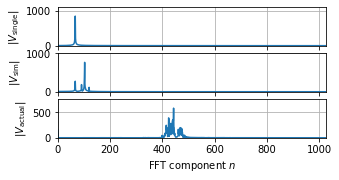

In [12]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(4.8, 2.4))

# Take FFTs of our signals.  Note the convention to name FFTs with a
# capital letter.

V_single = np.fft.fft(v_single)
V_sim = np.fft.fft(v_sim)
V_actual = np.fft.fft(v_actual)

N = len(V_single)


axes[0].plot(np.abs(V_single[:N // 2]))
axes[0].set_ylabel("$|V_\mathrm{single}|$")
axes[0].set_xlim(0, N // 2)
axes[0].set_ylim(0, 1100)

axes[1].plot(np.abs(V_sim[:N // 2]))
axes[1].set_ylabel("$|V_\mathrm{sim} |$")
axes[1].set_ylim(0, 1000)

axes[2].plot(np.abs(V_actual[:N // 2]))
axes[2].set_ylim(0, 750)
axes[2].set_ylabel("$|V_\mathrm{actual}|$")

axes[2].set_xlabel("FFT component $n$")

for ax in axes:
    ax.grid()

<!-- caption text="Range traces for: (a) single simulated target, (b) mutiple simulated targets, (c) real-world targets" --> 

Suddenly, the information makes sense!

The plot for $|V_\mathrm{single}|$ clearly shows a target at component 67, and
for $|V_\mathrm{sim}|$ shows the targets that produced the signal that was
uninterpretable in the time domain. The real radar
signal, $|V_\mathrm{actual}|$ shows a large number of targets between
component 400 and 500 with a large peak in component 443. This happens
to be an echo return from a radar illuminating the high wall of an
open-cast mine.

To get useful information from the plot, we must determine the range!
Again, we use the formula:

$$R_{n}=\frac{nv}{2B_{eff}}$$

In radar terminology, each DFT component is known as a *range bin*.

<!--
The sinusoid associated with the first component of the DFT has a
period exactly equal to the duration $T_{eff}$ of the time domain
signal, so $f_{1}=\frac{1}{T_{eff}}$. The other sinusoids in the
Fourier series are harmonics of this, $f_{n}=\frac{n}{T_{eff}}$.

The ranges associated with the DFT components follow from
Eqs. ([eq:difference frequency]) and ([eq:Effective bandwidth]) as

$$R_{n}=\frac{nv}{2B_{eff}}$$

and the associated DFT components are known as *range bins* in radar
terminology.

-->

This equation also defines the range resolution of the radar: targets
will only be distinguishable if they are separated by more than two
range bins, i.e.

$$\Delta R>\frac{1}{B_{eff}}.$$

This is a fundamental property of all types of radar.

<!--
The plot in Fig. ([fig:FFT range traces]) has a fundamental
shortcoming. The observable dynamic range is the signal is very
limited! We could easily have missed one of the targets in the trace
for $V_{5}$!  To ameliorate the problem, we plot the same FFTs but
this time against a logarithmic y-axis.  The traces were all
normalized by dividing the amplitudes with the maximum value.
-->

This result is quite satisfying—but the dynamic range is so large
that we could very easily miss some peaks.  Let's take the $\log$ as
before with the spectrogram:

Text(0.5, 0, 'range')

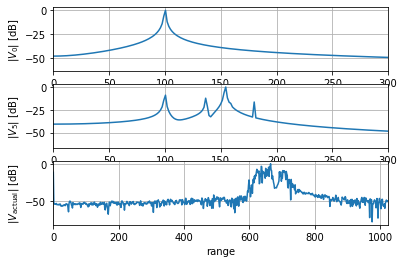

In [14]:
c = 3e8  # Approximately the speed of light and of
         # electromagnetic waves in air

fig, (ax0, ax1, ax2) = plt.subplots(3, 1)


def dB(y):
    "Calculate the log ratio of y / max(y) in decibel."

    y = np.abs(y)
    y /= y.max()

    return 20 * np.log10(y)


def log_plot_normalized(x, y, ylabel, ax):
    ax.plot(x, dB(y))
    ax.set_ylabel(ylabel)
    ax.grid()


rng = np.arange(N // 2) * c / 2 / Beff


log_plot_normalized(rng, V_single[:N // 2], "$|V_0|$ [dB]", ax0)
log_plot_normalized(rng, V_sim[:N // 2], "$|V_5|$ [dB]", ax1)
log_plot_normalized(rng, V_actual[:N // 2], "$|V_{\mathrm{actual}}|$ [dB]", ax2)

ax0.set_xlim(0, 300)  # Change x limits for these plots so that
ax1.set_xlim(0, 300)  # we are better able to see the shape of the peaks.
ax2.set_xlim(0, len(V_actual) // 2)
ax2.set_xlabel('range')

<!-- caption text="Logarithm of range traces" -->

The observable dynamic range is much improved in these plots. For
instance, in the real radar signal the *noise floor* of the radar has
become visible (i.e., the level where electronic noise in the system
starts to limit the radar's ability to detect a target).

<!-- The noise floor is ultimately caused by a phenomenon
called thermal noise that is produced by all conducting elements that
have resistance at temperatures above absolute zero, as well as by
shot noise, a noise mechanism inherent in all the electronic devices
that are used for processing the radar signal. The noise floor of a
radar limits its ability to detect weak echoes. -->


### Windowing, applied

We're getting there, but in the spectrum of the simulated signal, we
still cannot distinguish the peaks at 154 and 159 meters.  Who knows
what we're missing in the real-world signal!  To sharpen the peaks,
we'll return to our toolbox and make use of *windowing*.

<!--

The range traces in Fig. ([fig:Log range traces]) display a further
serious shortcoming. The signals $v_{1}$ and $v_{5}$ are composed of
pure sinusoids and we would ideally expect the FFT to produce line
spectra for these signals. The logarithmic plots show steadily
increasing values as the peaks are approached from both sides, to such
an extent that one of the targets in the plot for $|v_{5}|$ can hardly
be distinguished even though it is separated by several range bins
from the large target. The broadening is caused by *side lobes* in the
DFT. These are caused by an inherent clash between the properties of
the signal we analyzed and the signal produced by the inverse DFT.

-->

Here are the signals used thus far in this example, windowed with a
Kaiser window with $\beta=6.1$:

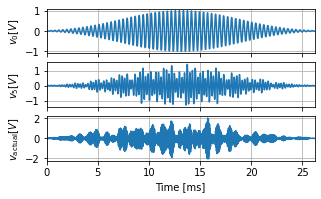

In [16]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(4.8, 2.8))

t_ms = t * 1000  # Sample times in milli-second

w = np.kaiser(N, 6.1)  # Kaiser window with beta = 6.1

for n, (signal, label) in enumerate([(v_single, r'$v_0 [V]$'),
                                     (v_sim, r'$v_5 [V]$'),
                                     (v_actual, r'$v_{\mathrm{actual}} [V]$')]):
        axes[n].plot(t_ms, w * signal)
        axes[n].set_ylabel(label)
        axes[n].grid()

axes[2].set_xlim(0, t_ms[-1])
axes[2].set_xlabel('Time [ms]');

<!-- caption text="Windowed signals for: (a) single simulated target, (b) multiple simulated targets, (c) real targets" -->

And the corresponding FFTs (or "range traces", in radar terms):

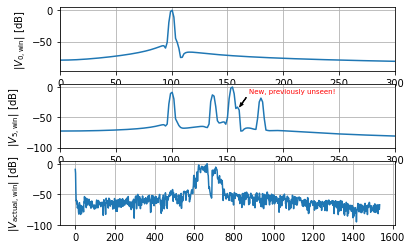

In [17]:
V_single_win = np.fft.fft(w * v_single)
V_sim_win = np.fft.fft(w * v_sim)
V_actual_win = np.fft.fft(w * v_actual)

fig, (ax0, ax1,ax2) = plt.subplots(3, 1)

log_plot_normalized(rng, V_single_win[:N // 2],
                        r"$|V_{0,\mathrm{win}}|$ [dB]", ax0)
log_plot_normalized(rng, V_sim_win[:N // 2],
                        r"$|V_{5,\mathrm{win}}|$ [dB]", ax1)
log_plot_normalized(rng, V_actual_win[:N // 2],
                        r"$|V_\mathrm{actual,win}|$ [dB]", ax2)

ax0.set_xlim(0, 300)  # Change x limits for these plots so that
ax1.set_xlim(0, 300)  # we are better able to see the shape of the peaks.

ax1.annotate("New, previously unseen!", (160, -35), xytext=(10, 15),
             textcoords="offset points", color='red', size='x-small',
             arrowprops=dict(width=0.5, headwidth=3, headlength=4,
                             fc='k', shrink=0.1));

<!-- caption text="Range traces (spectrum) of windowed signals" -->

Compare these with the earlier range traces. There is a dramatic
lowering in side lobe level, but at a price: the peaks have changed in
shape, widening and becoming less peaky, thus lowering the radar
resolution, that is, the ability of the radar to distinguish between
two closely space targets. The choice of window is a compromise
between side lobe level and resolution. Even so, referring to the
trace for $V_\mathrm{sim}$, windowing has dramatically increased our
ability to distinguish the small target from its large neighbor.

In the real radar data range trace windowing has also reduced the side
lobes. This is most visible in the depth of the notch between the two
groups of targets.

### Radar Images

Knowing how to analyze a single trace, we can expand to looking at
radar images.

The data is produced by a radar with a parabolic reflector antenna. It
produces a highly directive round pencil beam with a $2^\circ$
spreading angle between half-power points. When directed with normal
incidence at a plane, the radar will illuminate a spot of about $2$ meters in
diameter at a distance of 60 meters.
Outside this spot, the power drops off quite rapidly, but strong
echoes from outside the spot will nevertheless still be visible.

By varying the pencil beam's azimuth (left-right position) and
elevation (up-down position), we can sweep it across the target area
of interest.  When reflections are picked up, we can calculate the
distance to the reflector (the object hit by the radar signal).
Together with the current pencil beam azimuth and elevation, this
defines the reflector's position in 3D.

A rock slope consists of thousands of reflectors. A range bin can be
thought of as a large sphere with the radar at its center that
intersects the slope along a ragged line. The scatterers on this line
will produce reflections in this range bin. The wavelength of the
radar (distance the transmitted wave travels in one oscillation
second) is about 30 mm. The reflections from scatterers separated by
odd multiples of a quarter wavelength in range, about 7.5 mm, will
tend to interfere destructively, while those from scatterers separated
by multiples of a half wavelength will tend to interfere
constructively at the radar. The reflections combine to produce
apparent spots of strong reflections. This specific radar moves its
antenna in order to scan small regions consisting of $20^\circ$
azimuth and $30^\circ$ elevation bins scanned in steps of $0.5^\circ$.

We will now draw some contour plots of the resulting radar data.
Please refer to the diagram below to see how the different slices are
taken.  A first slice at fixed range shows the strength of echoes
against elevation and azimuth.  Another two slices at fixed elevation
and azimuth respectively shows the slope.  The stepped construction of
the high wall in an opencast mine is visible in the azimuth plane.

<img src="../figures/axes_slices.png"
     alt="Diagram showing azimuth, elevation and range slices through data volume"/>

(0.0, 1.0, 0.0, 1.0)

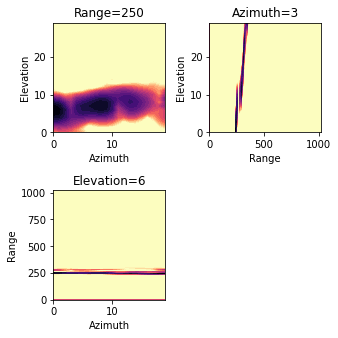

In [20]:
data = np.load('../data/radar_scan_1.npz')
scan = data['scan']

# The signal amplitude ranges from -2.5V to +2.5V.  The 14-bit
# analogue-to-digital converter in the radar gives out integers
# between -8192 to 8192.  We convert back to voltage by multiplying by
# $(2.5 / 8192)$.

v = scan['samples'] * 2.5 / 8192
win = np.hanning(N + 1)[:-1]

# Take FFT for each measurement
V = np.fft.fft(v * win, axis=2)[::-1, :, :N // 2]

contours = np.arange(-40, 1, 2)

# ignore MPL layout warnings
import warnings
warnings.filterwarnings('ignore', '.*Axes.*compatible.*tight_layout.*')

f, axes = plt.subplots(2, 2, figsize=(4.8, 4.8), tight_layout=True)

labels = ('Range', 'Azimuth', 'Elevation')

def plot_slice(ax, radar_slice, title, xlabel, ylabel):
    ax.contourf(dB(radar_slice), contours, cmap='magma_r')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_facecolor(plt.cm.magma_r(-40))


plot_slice(axes[0, 0], V[:, :, 250], 'Range=250', 'Azimuth', 'Elevation')
plot_slice(axes[0, 1], V[:, 3, :], 'Azimuth=3', 'Range', 'Elevation')
plot_slice(axes[1, 0], V[6, :, :].T, 'Elevation=6', 'Azimuth', 'Range')
axes[1, 1].axis('off')

<!-- caption text="Contour plots of range traces along various axes (see diagram)" -->

#### 3D visualization

We can also visualize the volume in three dimensions.

We first compute the argmax (the index of the maximum value) in the
range direction.  This should give an indication of the range at which
the radar beam hit the rock slope.  Each argmax index is converted to
a three-dimensional (elevation-azimuth-range) coordinate:

In [ ]:
r = np.argmax(V, axis=2)

el, az = np.meshgrid(*[np.arange(s) for s in r.shape], indexing='ij')

axis_labels = ['Elevation', 'Azimuth', 'Range']
coords = np.column_stack((el.flat, az.flat, r.flat))

Taking these coordinates, we project them onto the plane (by dropping
the range coordinate), and perform a Delaunay tesselation.  The
tesselation returns a set of indices into our coordinates that define
triangles (or simplices).  While the triangles are strictly speaking
defined on the projected coordinates, we use our original coordinates
for the reconstruction, thereby adding back the range component:

In [ ]:
from scipy import spatial

d = spatial.Delaunay(coords[:, :2])
simplexes = coords[d.vertices]

For display purposes, we swap the range axis to be the first:

In [ ]:
coords = np.roll(coords, shift=-1, axis=1)
axis_labels = np.roll(axis_labels, shift=-1)

Now, Matplotlib's `trisurf` can be used to visualize the result:

In [ ]:
# This import initializes Matplotlib's 3D machinery
from mpl_toolkits.mplot3d import Axes3D

# Set up the 3D axis
f, ax = plt.subplots(1, 1, figsize=(4.8, 4.8),
                     subplot_kw=dict(projection='3d'))

with plt.style.context('style/thinner.mplstyle'):
    ax.plot_trisurf(*coords.T, triangles=d.vertices, cmap='magma_r')

    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_zlabel(axis_labels[2], labelpad=-3)
    ax.set_xticks([0, 5, 10, 15])

# Adjust the camera position to match our diagram above
ax.view_init(azim=-50);

<!-- caption text="3-D visualization of estimated rock slope position" -->

### Further applications of the FFT

The examples above show just one of the uses of the FFT in
radar. There are many others, such as movement (Doppler) measurement
and target recognition.  The fast Fourier transform is pervasive, and is
seen anywhere from Magnetic Resonance Imaging (MRI) to statistics.
With the basic techniques that this chapter outlines in hand, you
should be well equipped to use it!

### Further reading

On the Fourier transform:

- A. Papoulis, *The Fourier Integral and Its Applications*,
  McGraw-Hill, 1960.
- Ronald A. Bracewell, *The Fourier Transform and Its Applications*,
  McGraw-Hill, 1986.

On radar signal processing:

- Mark A. Richards, *Principles of Modern Radar: Basic Principles*,
  SciTech, 2010
- Mark A. Richards, *Fundamentals of Radar Signal Processing*,
  McGraw-Hill, 2014.

<!-- exercise begin -->

**Exercise:** The FFT is often used to speed up image convolution
(convolution is the application of a moving filter mask).  Convolve an
image with ``np.ones((5, 5))``, using a) numpy's ``np.convolve`` and
b) ``np.fft.fft2``.  Confirm that the results are identical.

Hints:

 - The convolution of `x` and `y` is equivalent to `ifft2(X * Y)`, where
   `X` and `Y` are the FFTs of x and y respectively.
 - In order to multiply `X` and `Y`, they have to be the same size.
   Use `np.pad` to extend `x` and `y` with zeros (toward the right and
   bottom) *before* taking their FFT.
 - You may see some edge effects.  These can be removed by increasing
   the padding size, so that both `x` and `y` have dimensions
   `shape(x) + shape(y) - 1`.

<!-- solution begin -->

**Solution:**

In [21]:
# your code here

<!-- solution end -->

<!-- exercise end -->